In [20]:
import glob
import calendar
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from xbootstrap import block_bootstrap

In [4]:
infiles = glob.glob('/g/data/xv83/dbi599/bias-sandbox/data/pr/day/*.nc')
infiles = sorted(infiles)

In [5]:
ds = xr.open_mfdataset(infiles)
ds

<xarray.Dataset>
Dimensions:    (time: 44925, lat: 171, lon: 211, bnds: 2, nv: 2)
Coordinates:
  * time       (time) datetime64[ns] 1900-01-01T09:00:00 ... 2022-12-31T09:00:00
  * lat        (lat) float64 -44.0 -43.8 -43.6 -43.4 ... -10.6 -10.4 -10.2 -10.0
  * lon        (lon) float64 112.0 112.2 112.4 112.6 ... 153.4 153.6 153.8 154.0
Dimensions without coordinates: bnds, nv
Data variables:
    pr         (time, lat, lon) float32 dask.array<chunksize=(365, 171, 211), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(365, 171, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(365, 211, 2), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] dask.array<chunksize=(365, 2), meta=np.ndarray>
Attributes: (12/33)
    geospatial_lat_min:        -44.0
    geospatial_lat_max:        -10.0
    geospatial_lon_min:        112.0
    geospatial_lon_max:        154.0
    time_coverage_start:       1899-12-31T09:00:00
    date_created:              2017-01-17T22:13:51.976225
    ...                        ...
    licence:                   Data Licence: The grid data files in this AGCD...
    description:               This AGCD data is a snapshot of the operationa...
    date_issued:               2023-05-19 06:19:17
    attribution:               Data should be cited as : Australian Bureau of...
    copyright:                 (C) Copyright Commonwealth of Australia 2023, ...
    history:                   Tue Sep 26 12:59:52 2023: /g/data/xv83/dbi599/...

In [27]:
def monthly_climatology(da):
    """Calculate the monthly rainfall climatology"""
    
    da_monthly = da.resample(time='1M').sum('time')
    monthly_means = da_monthly.groupby('time.month').mean('time')
    
    return monthly_means

In [28]:
da_clim = monthly_climatology(ds['pr'])

In [8]:
cities = {
    'Hobart': {'lat': -42.9, 'lon': 147.3},
    'Melbourne': {'lat': -37.8, 'lon': 145.0},
    'Thredbo': {'lat': -36.5, 'lon': 148.3},
    'Sydney': {'lat': -33.9, 'lon': 151.2},
    'Brisbane': {'lat': -27.5, 'lon': 153.0},
    'Cairns': {'lat': -16.9, 'lon': 145.8},
    'Darwin': {'lat': -12.5, 'lon': 130.8},
    'Alice Springs': {'lat': -23.7, 'lon': 133.9},
    'Port Hedland': {'lat': -20.3, 'lon': 118.6},
    'Perth': {'lat': -32.0, 'lon': 115.9},
    'Adelaide': {'lat': -34.9, 'lon': 138.6},
}

xticks = np.arange(1, 13)
xtick_labels = [calendar.month_abbr[i] for i in xticks]

In [21]:
da_point = ds['pr'].sel(cities['Melbourne'], method='nearest')

In [24]:
da_point

<xarray.DataArray 'pr' (time: 44925)>
dask.array<rechunk-merge, shape=(44925,), dtype=float32, chunksize=(44925,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1900-01-01T09:00:00 ... 2022-12-31T09:00:00
    lat      float64 -37.8
    lon      float64 145.0
Attributes:
    long_name:      Precipitation
    standard_name:  precipitation_flux
    units:          mm d-1

In [25]:
da_point_bs = block_bootstrap(
    da_point.chunk({'time': -1}),
    blocks={'time': 365*20},
    n_iteration=1000,
)

In [26]:
da_point_bs

<xarray.DataArray 'pr' (time: 44925, iteration: 1000)>
dask.array<transpose, shape=(44925, 1000), dtype=float32, chunksize=(44925, 1000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1900-01-01T09:00:00 ... 2022-12-31T09:00:00
    lat      float64 -37.8
    lon      float64 145.0
Dimensions without coordinates: iteration

In [30]:
monthly_climatology(da_point_bs)

<xarray.DataArray 'pr' (month: 12, iteration: 1000)>
dask.array<stack, shape=(12, 1000), dtype=float32, chunksize=(1, 1000), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 -37.8
    lon      float64 145.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: iteration

In [18]:
def plot_city(city):
    """Plot city"""

    da_clim_point = da_clim.sel(cities[city], method='nearest')

    fig = plt.figure(figsize=[25, 6])

    ax1 = fig.add_subplot(131)
    ax1.plot(xticks, da_clim_point.values, label='1900-2022', color='black', linewidth=3.0, marker='o')
    step = 20
    start_years = np.arange(1900, 2022-step, step)
    for start_year in start_years:
        end_year = start_year + step -1
        da_sub_clim = monthly_climatology(ds['pr'].sel({'time': slice(f'{start_year}-01-01', f'{end_year}-12-31')}))
        da_sub_clim_point = da_sub_clim.sel(cities[city], method='nearest')
        ax1.plot(xticks, da_sub_clim_point.values, label=f'{start_year}-{end_year}', marker='o')
    ax1.set_ylabel('monthly mean rainfall (mm)')
    ax1.set_xticks(xticks, xtick_labels)
    ax1.legend()
    ax1.grid()

    ax2 = fig.add_subplot(132, sharey=ax1)
    ax2.plot(xticks, da_clim_point.values, label='1900-2022', color='black', linewidth=3.0, marker='o')
    step = 30
    start_years = np.arange(1900, 2022-step, step)
    for start_year in start_years:
        end_year = start_year + step -1
        da_sub_clim = monthly_climatology(ds['pr'].sel({'time': slice(f'{start_year}-01-01', f'{end_year}-12-31')}))
        da_sub_clim_point = da_sub_clim.sel(cities[city], method='nearest')
        ax2.plot(xticks, da_sub_clim_point.values, label=f'{start_year}-{end_year}', marker='o')
    ax2.set_ylabel('monthly mean rainfall (mm)')
    ax2.set_xticks(xticks, xtick_labels)
    ax2.legend()
    ax2.grid()
    
    ax3 = fig.add_subplot(133, sharey=ax1)
    ax3.plot(xticks, da_clim_point.values, label='1900-2022', color='black', linewidth=3.0, marker='o')
    step = 40
    start_years = np.arange(1900, 2022-step, step)
    for start_year in start_years:
        end_year = start_year + step -1
        da_sub_clim = monthly_climatology(ds['pr'].sel({'time': slice(f'{start_year}-01-01', f'{end_year}-12-31')}))
        da_sub_clim_point = da_sub_clim.sel(cities[city], method='nearest')
        ax3.plot(xticks, da_sub_clim_point.values, label=f'{start_year}-{end_year}', marker='o')
    ax3.set_ylabel('monthly mean rainfall (mm)')
    ax3.set_xticks(xticks, xtick_labels)
    ax3.legend()
    ax3.grid()
    
    plt.suptitle(f'Monthly climatology - {city}')
    plt.show()

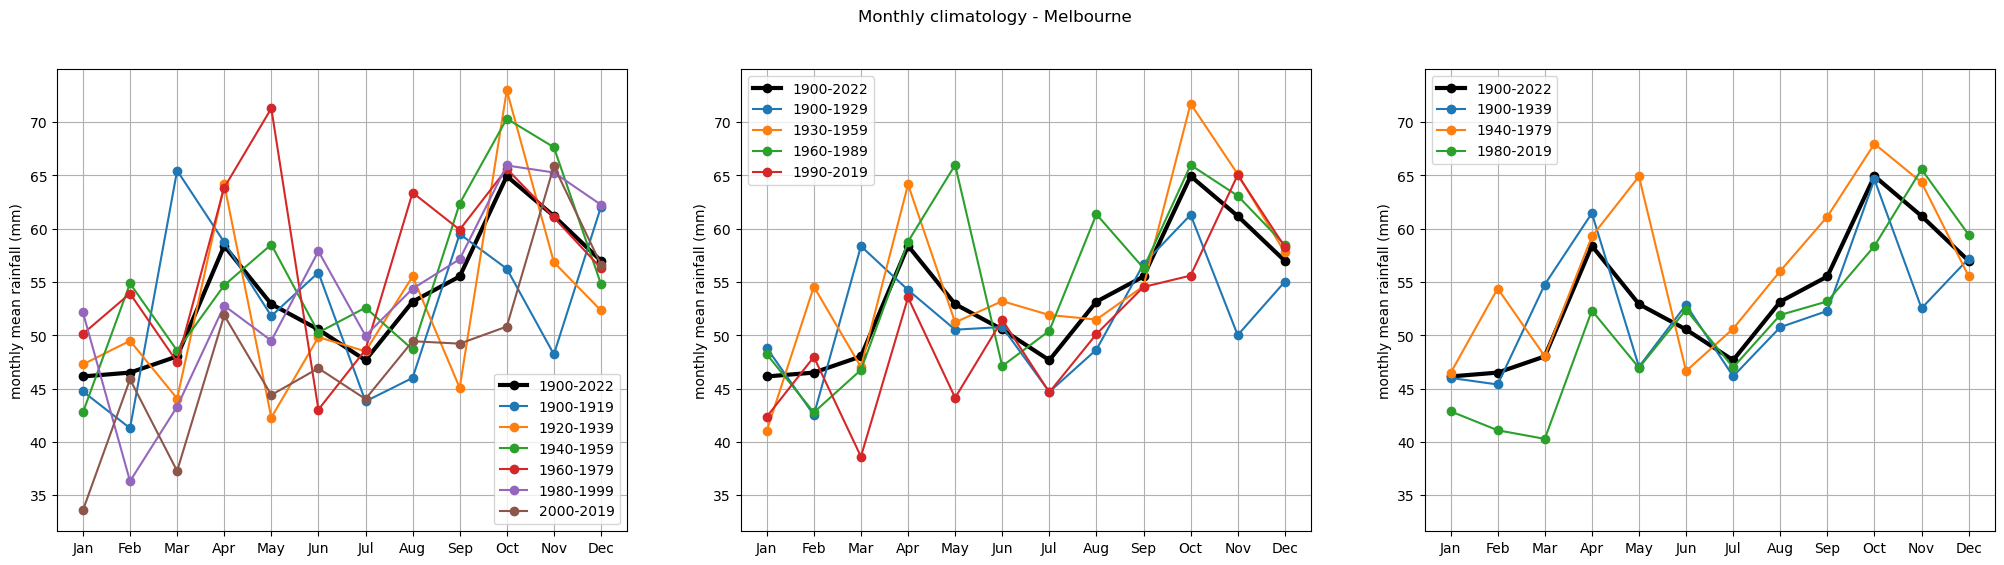

In [19]:
plot_city('Melbourne')

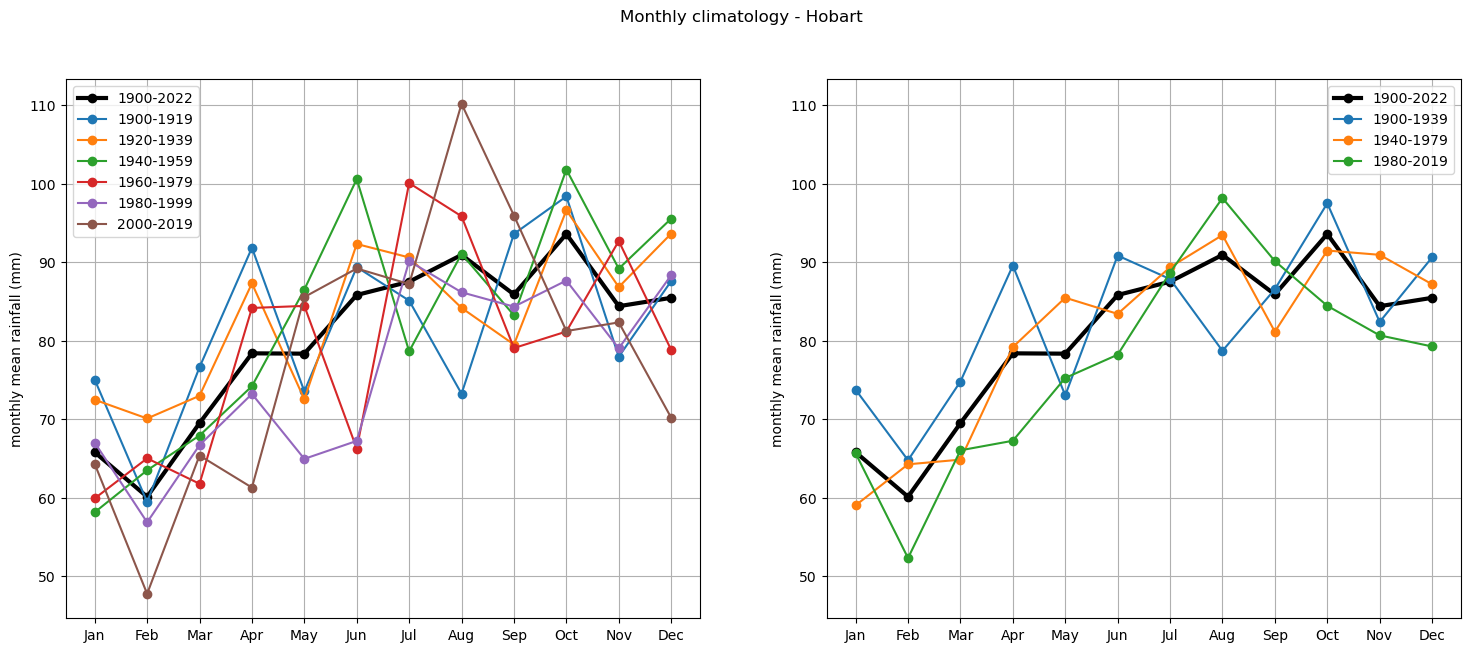

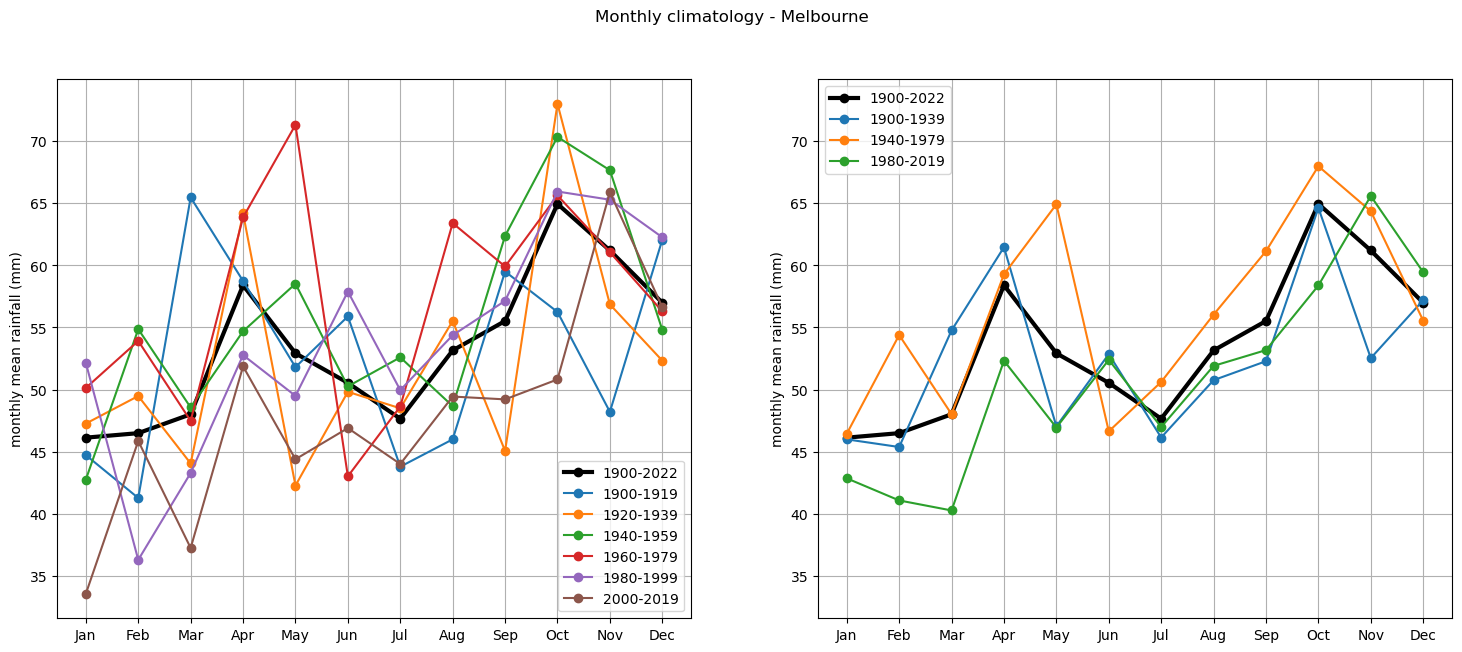

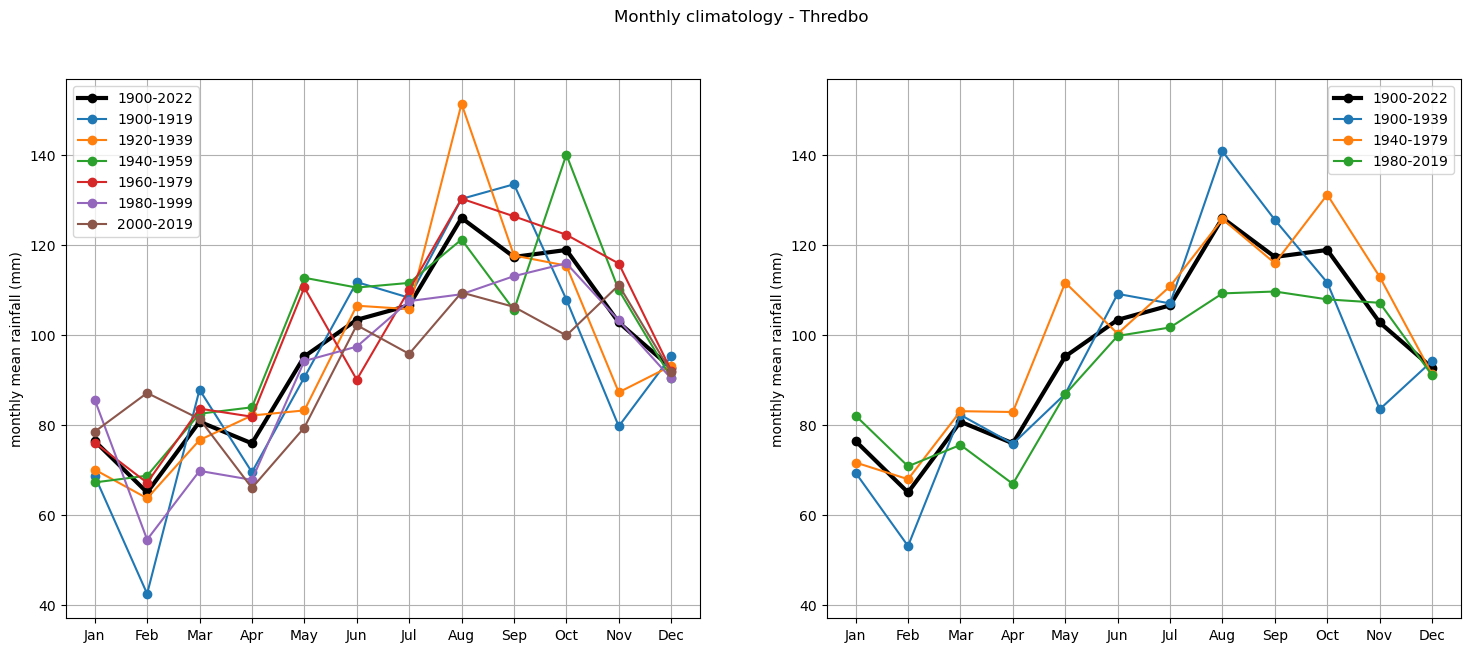

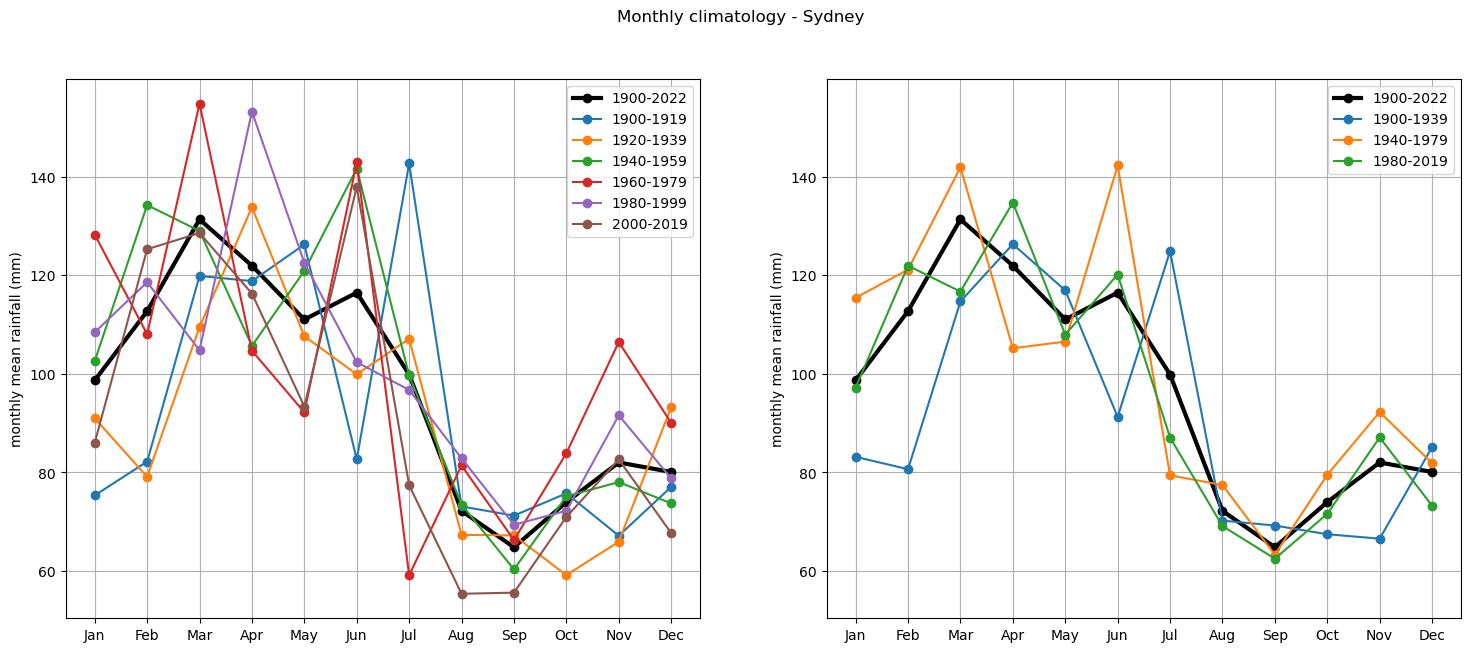

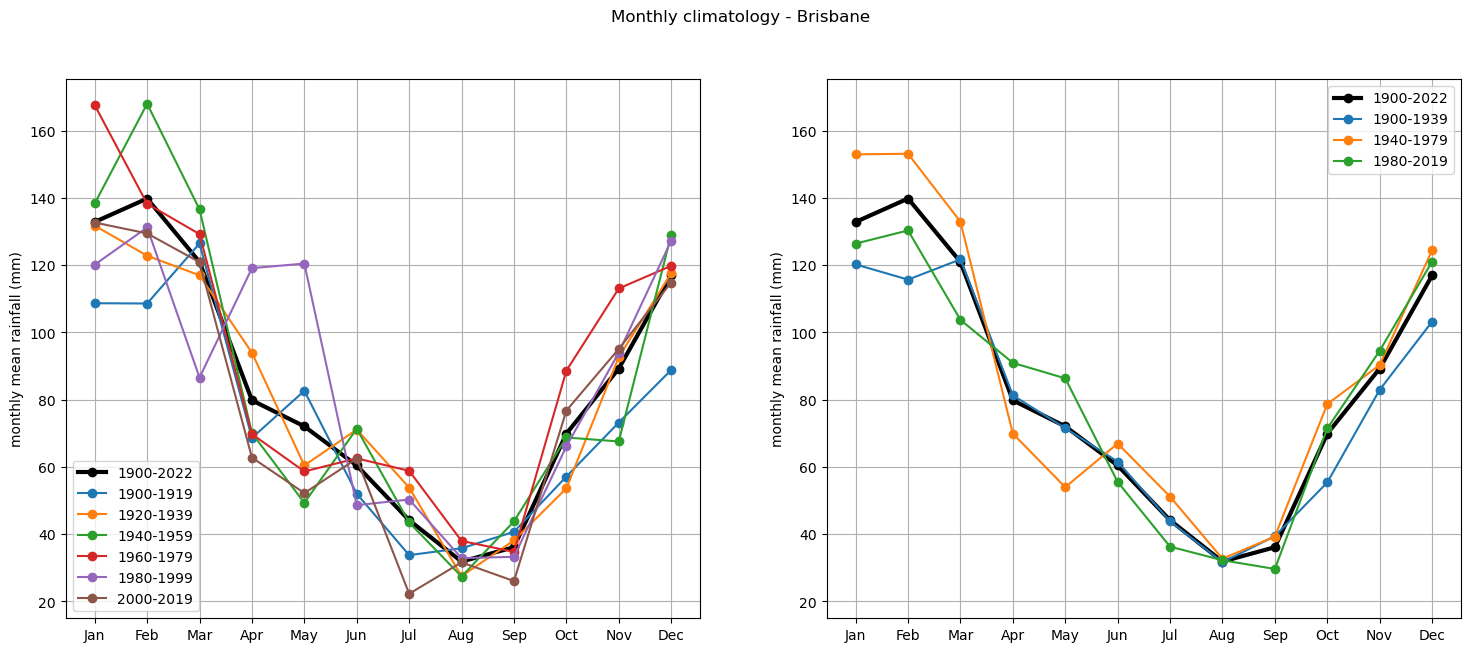

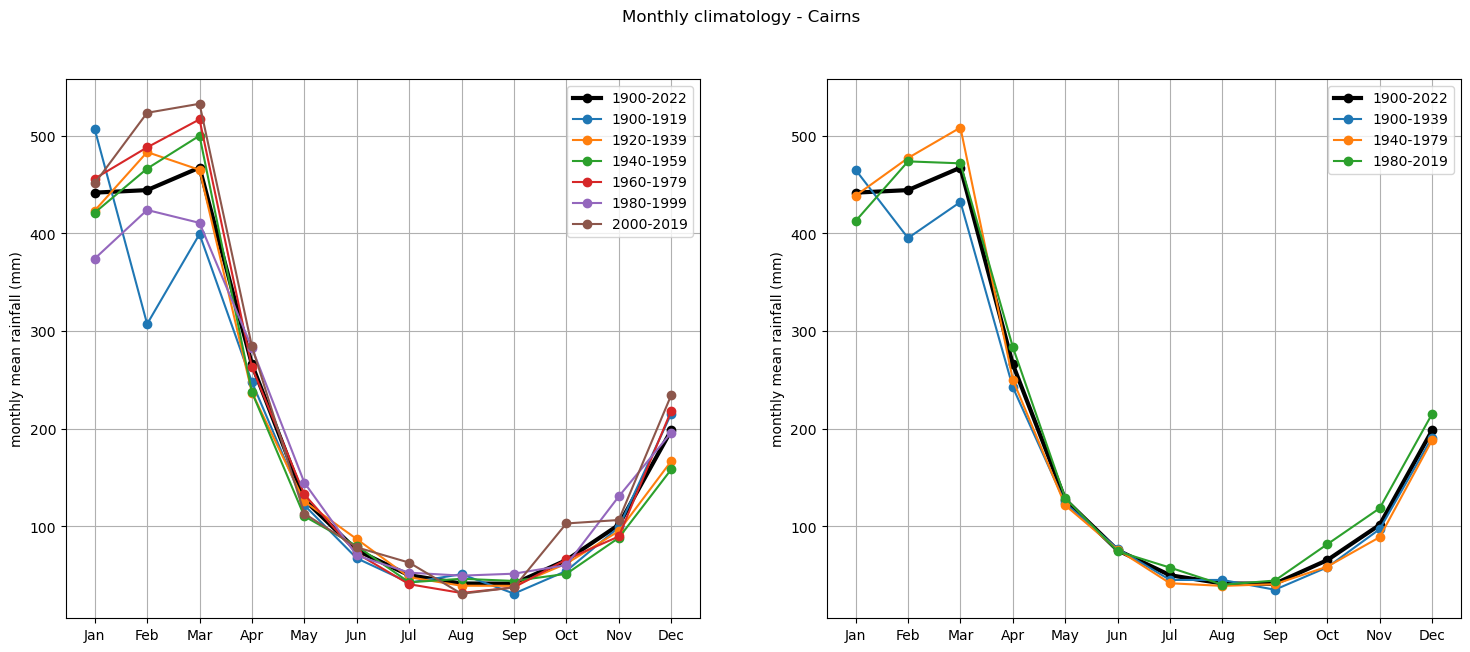

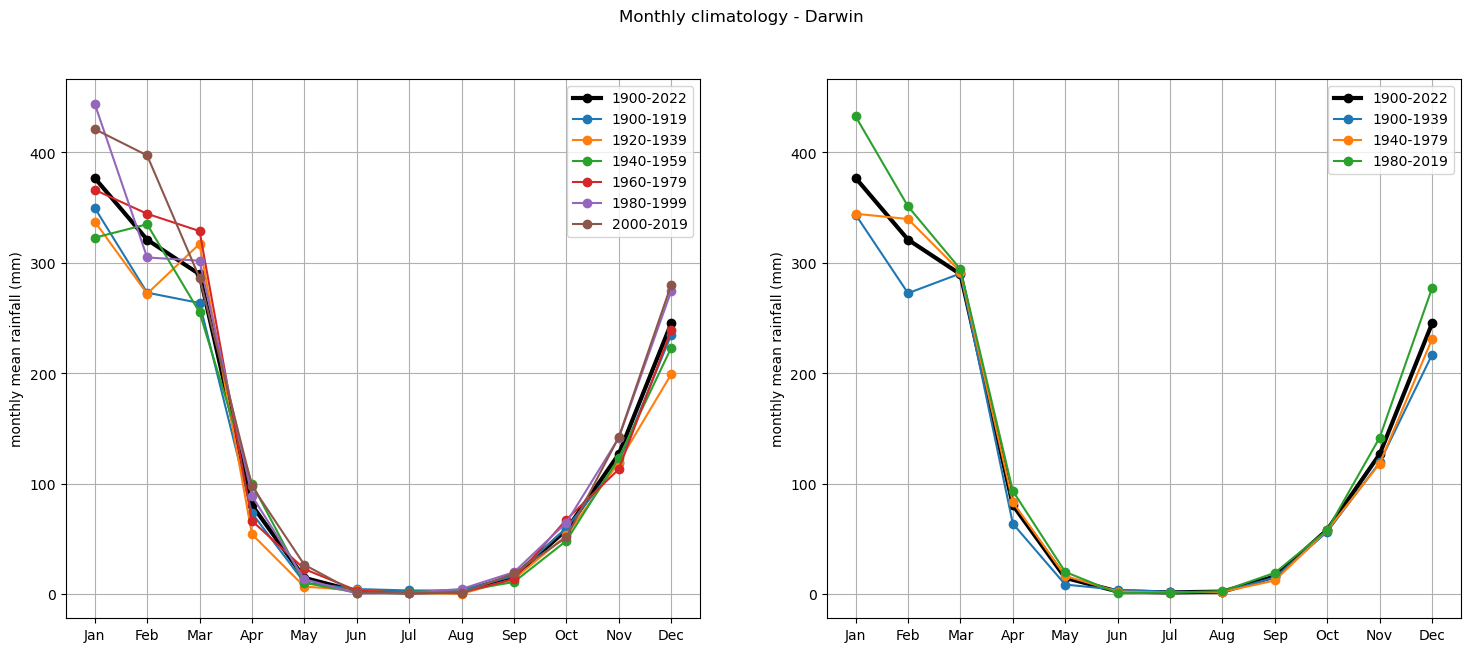

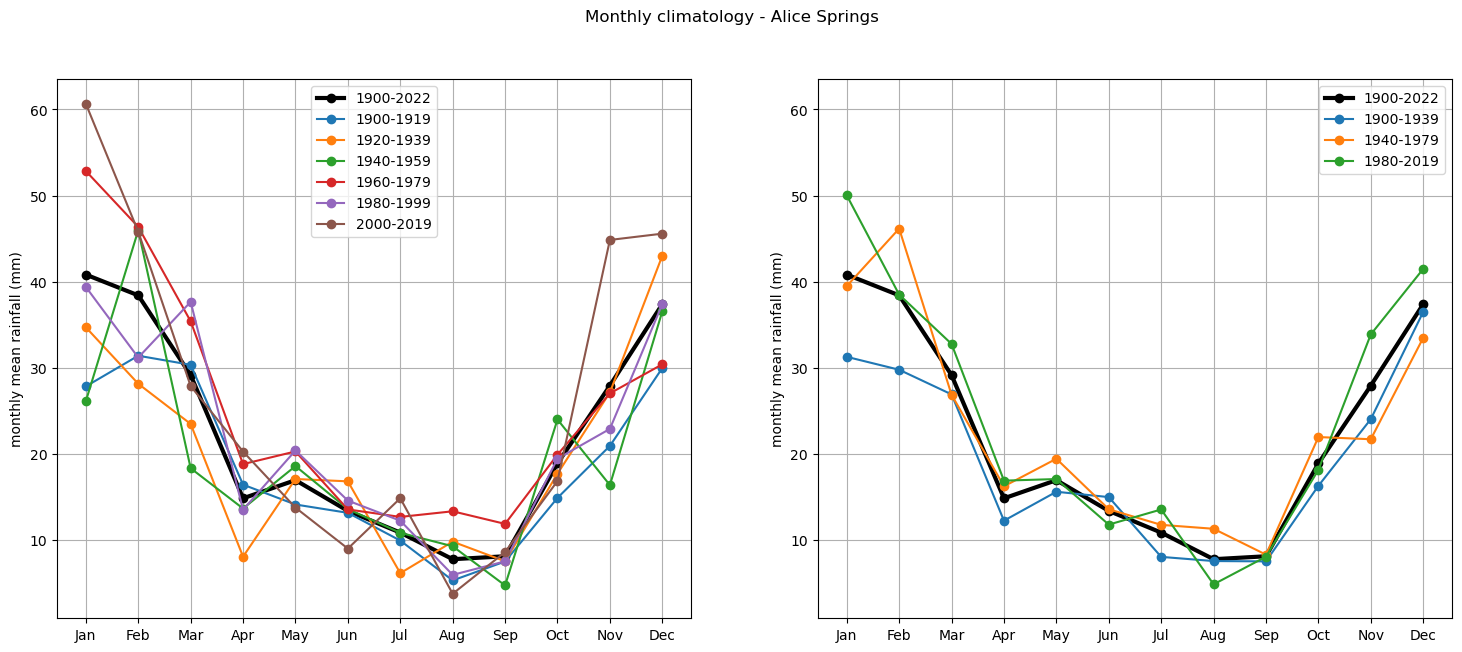

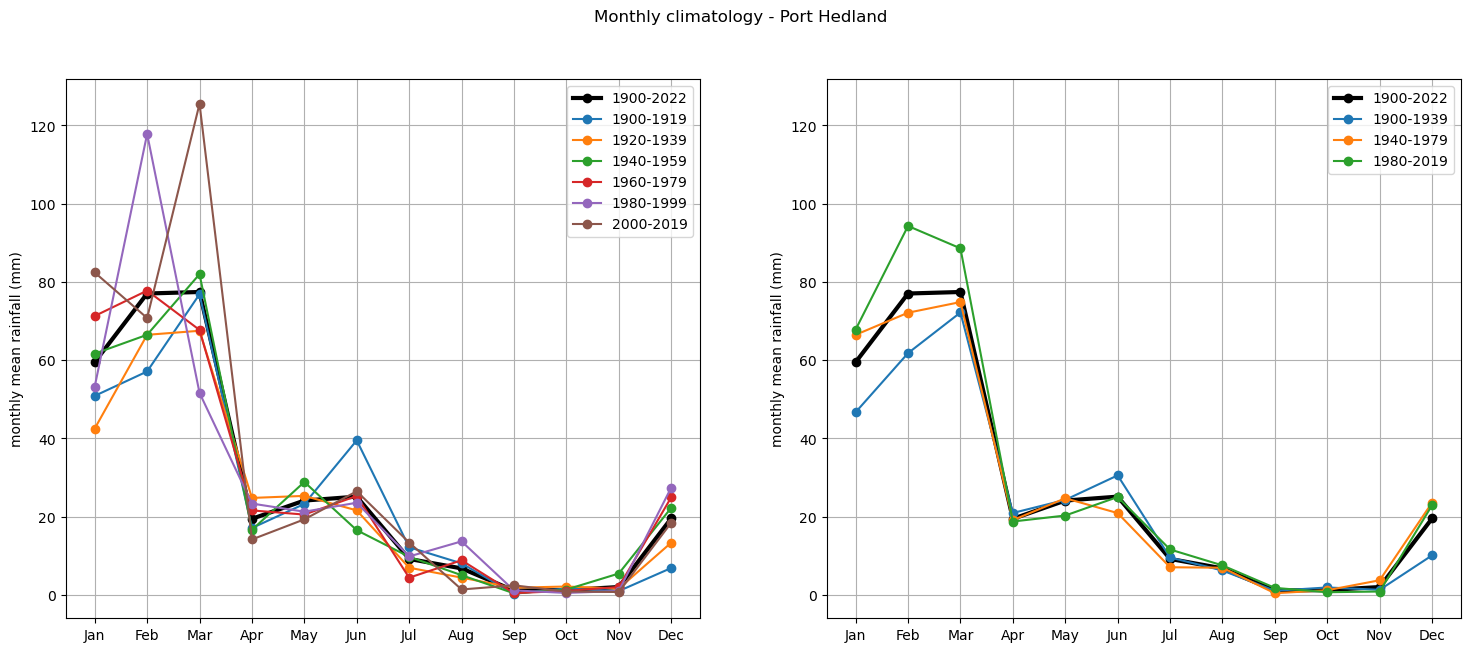

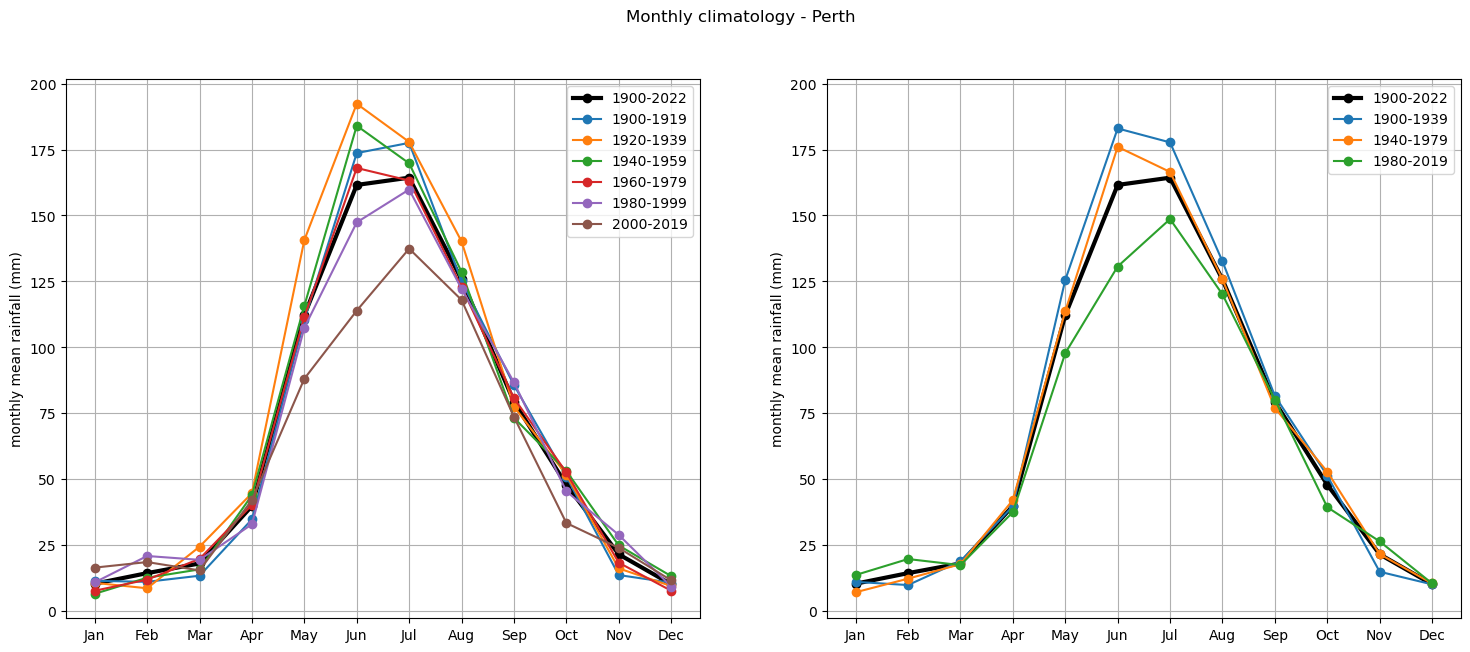

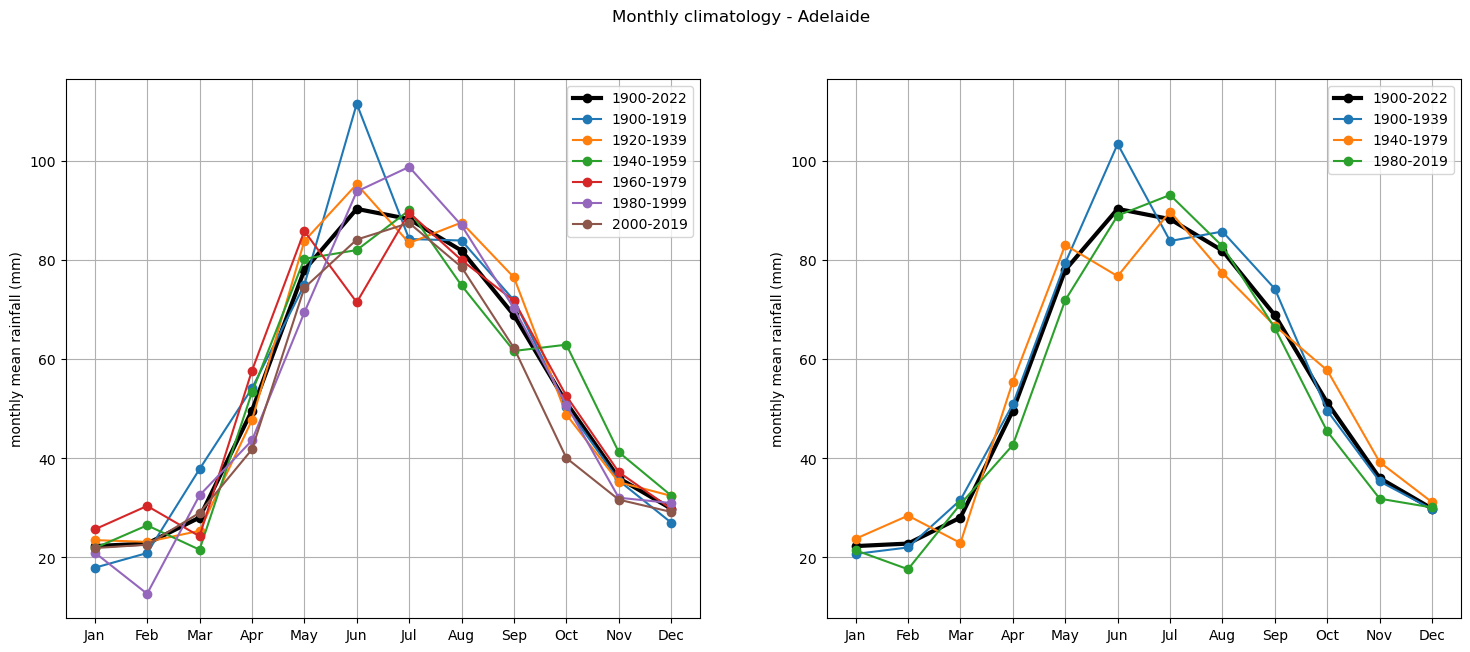

In [15]:
for city in cities:
    plot_city(city)